In [19]:
import pyprob #https://github.com/probprog/pyprob #!pip install pyprob
from pyprob import Model 
from pyprob.distributions import Categorical, Uniform, Normal
import numpy as np
import torch
import cv2
from pyprob import PriorInflation, InferenceEngine, InferenceNetwork
import matplotlib.pyplot as plt

In [20]:
# pip install opencv-python

In [60]:
class ImagesGen(Model):
    def __init__(self, name='ImagesModel', opt = None):
        super().__init__(name=name)
        self.opt = opt

        self.height, self.width = 75, 75
        self.colors = [
            (0,0,255),##r
            (0,255,0),##g
            (255,0,0),##b
            (0,156,255),##o
            (128,128,128),##k
            (0,255,255)##y
            ]
        self.size = 5

    def forward(self):
        # Initialize images with 255 (white background)
        img = np.ones((self.height,self.width, 3), dtype=np.uint8)*255
        objects = []
        for color_id,color in enumerate(self.colors):  
            center = self.center_generate(objects)
            shape = pyprob.sample(Categorical(probs=[0.5,0.5]), name=f"{color_id}_shape").item()
            if shape:
                start = (center[0]-self.size, center[1]-self.size)
                end = (center[0]+self.size, center[1]+self.size)
                cv2.rectangle(img, start, end, color, -1)
                objects.append((color_id,center,'r'))
            else:
                center_ = (center[0], center[1])
                cv2.circle(img, center_, self.size, color, -1)
                objects.append((color_id,center,'c'))

        rendered_img = torch.tensor(img).view(-1) # I had to add this for some reason --> check if it is right
        pyprob.tag(rendered_img, name="rendered_image")
        
        #Use VAE encoded represenation
        # encoded_mu, encoded_sigma = encoder(rendered_img)
        # pyprob.observe(Normal(encoded_mu, encoded_sigma), name="observed_image")
        pyprob.observe(Normal(rendered_img, 1), name="observed_image")

    def center_generate(self, objects):
        while True:
            pas = True
            center_x = pyprob.sample(Categorical(probs=[0] * self.size + [1/(self.height-2*self.size)]*(self.height-2*self.size)), name=f"{len(objects)}_center_x").item()
            center_y = pyprob.sample(Categorical(probs=[0] * self.size + [1/(self.height-2*self.size)]*(self.height-2*self.size)), name=f"{len(objects)}_center_y").item()
            #self.np.random.randint(0+size, img_size - size, 2)        
            center = torch.tensor([center_x, center_y])
            if len(objects) > 0:
                for name,c,shape in objects:
                    if torch.sum(((center - c) ** 2)) < ((self.size * 2) ** 2):
                        pas = False
            if pas:
                return center

In [61]:
def plot_trace(trace_image, title):
    img = np.array(trace_image.view(75,75, 3))
    img = img.astype("uint8")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.title(title)
    plt.imshow(img)
    plt.show()

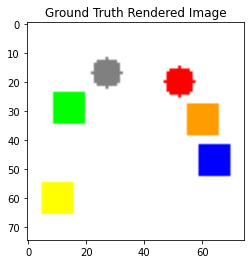

In [62]:
model = ImagesGen()
    
gt_trace = next(model._trace_generator(inference_engine=InferenceEngine.RANDOM_WALK_METROPOLIS_HASTINGS))
plot_trace(gt_trace["rendered_image"], "Ground Truth Rendered Image")

In [66]:
gt_trace["rendered_image"]

tensor([255, 255, 255,  ..., 255, 255, 255], dtype=torch.uint8)

In [65]:
model.learn_inference_network(num_traces=500,
                              observe_embeddings={'observed_image' : observed_image},
                              inference_network=pyprob.InferenceNetwork.LSTM)

Creating new inference network...


RuntimeError: Tensor.__contains__ only supports Tensor or scalar, but you passed in a <class 'str'>.

In [35]:
# sample from posterior (500 samples)
posterior_results = model.posterior_results(
         num_traces=500, # the number of samples estimating the posterior
         inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK, # specify which inference engine to use
         observe={'observed_image' : gt_trace} # assign values to the observed values
         )

RuntimeError: Cannot run inference engine IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK because no inference network for this model is available. Use learn_inference_network or load_inference_network first.